## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env1 import TicTacToe #- import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
env = TicTacToe()

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [6]:
max_epsilon = 1.0
min_epsilon = 0.001

In [7]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, episode):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*episode)
    z = np.random.random()
        
    if z > epsilon:
        qstate = Q_state(state)
        action = max(Q_dict[qstate],key=Q_dict[qstate].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        #env.action_space() returns a tuple with 0th element contains list of valid actions for agent 
        agent_action_gen = env.action_space(state)[0]
        agent_action = [x for x in agent_action_gen]
        action = random.choice(agent_action)    #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [8]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [9]:
# Initialise states to be tracked
def initialise_tracking_states():
    states_to_track = [('5-3-x-6-x-x-x-8-x',(2,7)),
                       ('x-4-5-1-8-x-x-x-x',(7,3)),
                       ('8-3-x-x-x-x-x-x-x',(2,5)),
                       ('x-x-x-x-x-x-x-x-x',(0,1))]    #select some 4 Q-values
    for state_value in states_to_track:
        state = state_value[0]
        action = state_value[1]
        States_track[state][action] = []  

In [10]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

In [13]:
States_track

defaultdict(dict,
            {'5-3-x-6-x-x-x-8-x': {(2, 7): []},
             'x-4-5-1-8-x-x-x-x': {(7, 3): []},
             '8-3-x-x-x-x-x-x-x': {(2, 5): []},
             'x-x-x-x-x-x-x-x-x': {(0, 1): []}})

#### Define hyperparameters  ---write your code here

In [14]:
EPISODES = 5000000
# Learning Rate
ALPHA = 0.01

# multiplication factor for future state reward
GAMMA = 0.91               

### Q-update loop ---write your code here

In [15]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env.reset()
    terminated = False  
    current_state = env.state    

    # Add current state to dictionary this will result in computing all state action pair value and defaulting it to 0,
    # if not already exists.
    add_to_dict(current_state)  

    while terminated != True:  

        current_action = epsilon_greedy(current_state, episode)
        current_qstate = Q_state(current_state)
        # invoke env to apply the action and get the reward and next state.
        response  = env.step(current_state, current_action)

        new_state = response[0]
        reward = response[1]
        terminated = response[2]

        # add new state to q dict
        add_to_dict(new_state)
        # convert next state to string to get the corresponding reward from Q_dict
        new_qstate = Q_state(new_state)
        # If the episode(game) not terminated then find calculate the q value as 
        # q(s,a)=q(s,a)+α((r+γ maxaq(s′,a))−q(s,a))
        if terminated != True:
            max_next = max(Q_dict[new_qstate],key=Q_dict[new_qstate].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[current_qstate][current_action] += ALPHA * ((reward + (GAMMA * (Q_dict[new_qstate][max_next])))
                                                      - Q_dict[current_qstate][current_action]) 
        else:
            #If episode is terminated then there is no action for next state and hence γ maxaq(s′,a) will be 0
            Q_dict[current_qstate][current_action] += ALPHA * ((reward - Q_dict[current_qstate][current_action]))

        current_state = new_state
        save_tracking_states()

elapsed_time = time.time() - start_time
save_obj(States_track,'States_track')   
save_obj(Q_dict,'Q_dict')

In [17]:
print ("Time in seconds: ", elapsed_time)
print ("Time in Hours: ", elapsed_time/3600)

Time in seconds:  5768.5316705703735
Time in Hours:  1.6023699084917704


#### Check the Q-dictionary

In [20]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.3699705621342562,
              (0, 3): -1.2880246648426732,
              (0, 5): -1.3386446077409602,
              (0, 7): -1.1607840358831159,
              (0, 9): -0.5972530248420838,
              (1, 1): 5.733380296516922,
              (1, 3): -1.2575617960384988,
              (1, 5): -1.2791276779937961,
              (1, 7): -1.2639265952839263,
              (1, 9): -1.3144482001853113,
              (2, 1): -1.3615186121407838,
              (2, 3): -1.2168096286998507,
              (2, 5): -1.3154958618046504,
              (2, 7): -1.2554588427490923,
              (2, 9): 0.6113220895657993,
              (3, 1): -1.3363259285849722,
              (3, 3): -1.1363219964158071,
              (3, 5): -1.2628491940545297,
              (3, 7): -1.2182268205402287,
              (3, 9): -1.2666080938427098,
              (4, 1): -1.3822281978073618,
              (4, 3): -1.3555518279920766,
              (4, 

In [18]:
len(Q_dict)

2265842

**Let us check for actions and q-value for: '6-x-x-8-3-9-x-x-x' - Note that this combination exists in Q_dict, may not be same if you re-execute again (depends on number of episodes)**

In [21]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['6-x-x-8-3-9-x-x-x']

{(1, 1): -0.01,
 (1, 5): -0.01,
 (1, 7): -0.1,
 (2, 1): -0.01,
 (2, 5): -0.01,
 (2, 7): -0.01,
 (6, 1): 0.58519850599,
 (6, 5): 0,
 (6, 7): -0.01,
 (7, 1): -0.01,
 (7, 5): -0.01,
 (7, 7): 0,
 (8, 1): 0,
 (8, 5): 0,
 (8, 7): -0.0199}

Observe that : Highest q-value for (6, 1), This will make sure first colum matrix will be summing up to 15 and hence agent will win.
    Action: Place 1 at index location 6 (index start at 0)
    
    After action '6-x-x-8-3-9-1-x-x'
    Hence first column becomes 6-8-1 = 15

#### Check the states tracked for Q-values convergence
(non-evaluative)

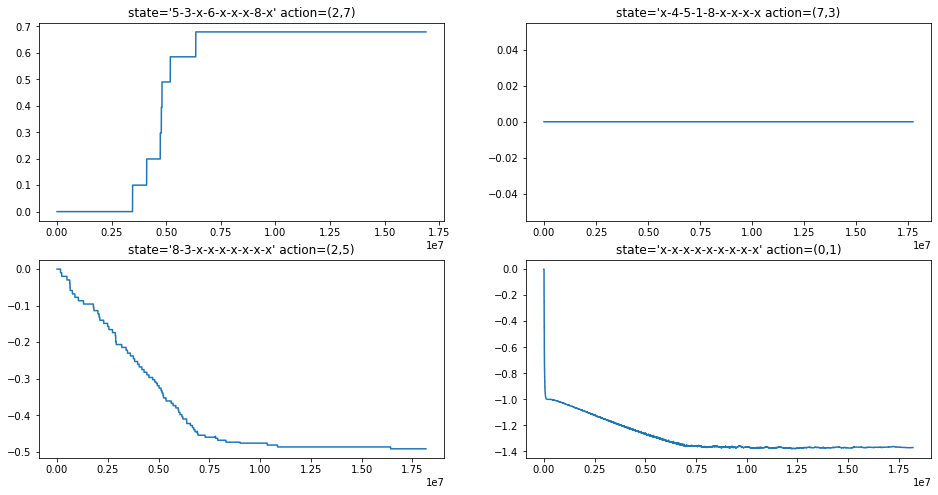

In [24]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(16,8))
plt.subplot(221)
plt.title("state='5-3-x-6-x-x-x-8-x' action=(2,7)")
xaxis =  range(0, len(States_track['5-3-x-6-x-x-x-8-x'][(2,7)]))
plt.plot(xaxis,np.asarray(States_track['5-3-x-6-x-x-x-8-x'][(2,7)]))

plt.subplot(222)
plt.title("state='x-4-5-1-8-x-x-x-x action=(7,3)")
xaxis =  range(0, len(States_track['x-4-5-1-8-x-x-x-x'][(7,3)]))
plt.plot(xaxis,np.asarray(States_track['x-4-5-1-8-x-x-x-x'][(7,3)]))

plt.subplot(223)
plt.title("state='8-3-x-x-x-x-x-x-x' action=(2,5)")
xaxis =  range(0, len(States_track['8-3-x-x-x-x-x-x-x'][(2,5)]))
plt.plot(xaxis,np.asarray(States_track['8-3-x-x-x-x-x-x-x'][(2,5)]))

plt.subplot(224)
plt.title("state='x-x-x-x-x-x-x-x-x' action=(0,1)")
xaxis =  range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(0,1)]))
plt.plot(xaxis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(0,1)]))
plt.show()

**This is as expected first two states are winning states and hence it has a +ve or 0 qvalue (0 q value since though te state was encountered action wasn't picked). Others are random states so it has got a -ve value. Also all the values are converging**

**Q-VALUES OF STATE ACTION PAIR TRACKED**

['5-3-x-6-x-x-x-8-x'][(2,7)] - This is a winnning cobination expected to have 0 or higher value. 0 - is considered as the state would have encountered only once or a very few time, but the same action is not picked randomly.

In [28]:
Q_dict['5-3-x-6-x-x-x-8-x'][(2,7)]

0.6793465209301

['x-4-5-1-8-x-x-x-x'][(7,3)]- This is a winnning cobination expected to have 0 or higher value. 0 - is considered as the state would have encountered only once or a very few time, but the same action is not picked randomly.

In [29]:
Q_dict['x-4-5-1-8-x-x-x-x'][(7,3)]

0

['8-3-x-x-x-x-x-x-x'][(2,5)]- This isn't a winnning cobination hence expected to have -ve or 0 value. 0 - is considered as the state would have encountered only once or a very few time, but the same action is not picked randomly.

In [30]:
Q_dict['8-3-x-x-x-x-x-x-x'][(2,5)]

-0.49174228599722425

['x-x-x-x-x-x-x-x-x'][(0,1)]- This is an intermediate state hence expected to have -ve or 0 value. 0 - is considered as the state would have encountered only once or a very few time, but the same action is not picked randomly.

In [31]:
Q_dict['x-x-x-x-x-x-x-x-x'][(0,1)]

-1.3699705621342562

### Epsilon - decay check

In [25]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

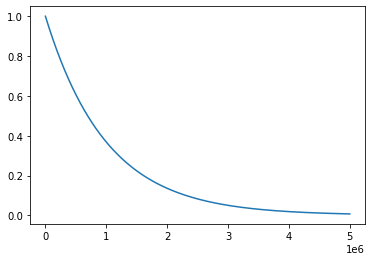

In [26]:
plt.plot(time, epsilon)
plt.show()